## Table of Contents
- [**Importing packages and reading the data**](#import)
- [**Reading the data**](#read)
- [**Feature preparing**](#prep)
- [**Data annotation**](#annotation)
- [**EDA and Feature Engineering**](#EDA)
- [**slice training and testing datasets**](#slice)
- [**get the groups set**](#groups)
- [**Machine Learning Models**](#ml)
    - [Data Preparation](#prep)
    - [Point-wise](#point)
    - [List-wise](#list)
    - [Pair-wise](#pair)
    - [Hyperparameters Tuning ](#hyper)
    - [Model Interpretation ](#interpret)

***

### Importing packages and reading the data <a class="anchor" id="import"></a>

In [64]:
# import some libraries
import pandas as pd
from sklearn.metrics import ndcg_score, dcg_score
import numpy as np
import xgboost as xgb
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
import random
from random import random as randomFunc
import pickle

import matplotlib.pyplot as plt
import seaborn as sns


### Reading the data <a class="anchor" id="read"></a>

In [74]:
#reading data
data = pd.read_csv("train_data.csv")
data.head()

,Unnamed: 0,query,document,query_length,document_length,jaccard_entire,sub_jaccard,prefix_match,elasticsearch_score,distance,tweets_count,tweets_average_length,replies_count,retweets_count,likes_count,popularity,hashtags,mentions,label
0,0,1025 Ruyi,1020,9,4,0.0,0.50,True,8.896750,388.193314,15,67.000000,0,0,0,1.733333,0,1,5.0
1,1,1025 Ruyi,NYPD 102 PCT,9,12,0.0,0.25,False,5.598911,403.378756,21,172.380952,0,0,0,1.553445,48,3,3.0
2,2,1025 Ruyi,Public School 105,9,17,0.0,0.00,False,5.598911,386.628819,70,145.642857,0,0,0,1.634557,97,11,4.0
3,0,1060,1060 Restaurant,4,15,0.5,0.50,True,9.674871,0.005142,1,63.000000,0,0,0,1.000000,0,0,5.0
4,1,1060,1020,4,4,0.0,0.00,False,8.752578,307.384579,15,67.000000,0,0,0,1.733333,0,1,1.0


### feature preparing <a class="anchor" id="prep"></a>

<div class="alert alert-warning">
We need to delete queries with one document
 
</div> 

In [75]:
# get the values cout for each query
query_counts = data['query'].value_counts()
# slice the ones that have more than one document
query_counts = list(query_counts[query_counts.values>1].keys())
data = data[data['query'].isin(query_counts) ]

<div class="alert alert-warning">
<b>Unnamed: 0</b> is the document index for each query. it won't be useful in the future so we'll drop it <br>
 
</div>

In [76]:
data = data.drop(["Unnamed: 0"],axis=1)


<div class="alert alert-warning">
<b>prefix_match</b> needs to be transformed into binary values instead of true false <br>
 
</div>

In [93]:
data['prefix_match'] = data['prefix_match'].map({False:0, True:1})

### data annotation <a class="anchor" id="annotation"></a>

<div class="alert alert-info">
the data lacks labels, so in the next few steps we will be generating labels with a bit of randomness from the features
</div>

In [77]:
def scaling(nubmers):
    """
    min max scale in range 1 to 5
    [params]: numbers : the list of numbers to change the scale
    [return]: the scaled numbers
    """
    
    # change the numbers scale
    scale = preprocessing.minmax_scale(nubmers, feature_range = ((1, 2, 3, 4, 5)[-len(nubmers):][0],
                                                                (1, 2, 3, 4, 5)[-len(nubmers):][-1]))
    # return the new numbers
    return np.around(scale)

In [78]:
def get_random():
    """
    get random column name from the dataframe columns
    [return]: the random column name
    """
    
    # use the choice method to get random column
    return np.random.choice(data.columns[3:-1])

In [79]:
# define the label list to empty
label = []

In [80]:
# pick two columns randomly and extract label from them
# go over each query group. scale the vlaues of the two random columns we get. multiply them and scale the result
data.groupby(['query']).apply(lambda x: label.extend(scaling(scaling(x[get_random()])*scaling(x[get_random()]))))

""


In [81]:
# add the new label
data['label'] = label

In [82]:
# get the unique values in the label column
data['label'].unique()

array([5., 4., 2., 3., 1.])

<div class="alert alert-success">
We've added the labels successfully in range of 1-5 by taking 2 random feature, multiplying them by each other and scaling the result down. 
</div>

### EDA and Feature Engineering  <a class="anchor" id="EDA"></a>

In [83]:
data.describe()

,query_length,document_length,jaccard_entire,sub_jaccard,elasticsearch_score,distance,tweets_count,tweets_average_length,replies_count,retweets_count,likes_count,popularity,hashtags,mentions,label
count,80159.000000,80159.000000,80159.000000,80159.000000,80159.000000,80159.000000,80159.000000,80159.000000,80159.0,80159.0,80159.0,80159.000000,80159.000000,80159.000000,80159.000000
mean,6.919884,11.992690,0.160851,0.274959,7.802068,88.684938,106.907172,74.914885,0.0,0.0,0.0,1.460022,4.190983,53.900523,3.133422
std,2.148494,6.070596,0.222628,0.279767,1.979453,142.486644,192.424608,15.007580,0.0,0.0,0.0,0.317811,21.023024,112.263595,1.476134
min,2.000000,1.000000,0.000000,0.000000,1.930812,0.000000,1.000000,42.000000,0.0,0.0,0.0,0.876963,0.000000,0.000000,1.000000
25%,5.000000,8.000000,0.000000,0.000000,6.586134,1.401515,6.000000,66.948718,0.0,0.0,0.0,1.181818,0.000000,1.000000,2.000000
50%,7.000000,11.000000,0.000000,0.250000,7.644805,10.032602,28.000000,72.564626,0.0,0.0,0.0,1.500000,0.000000,10.000000,3.000000
75%,9.000000,15.000000,0.333333,0.500000,8.748089,129.230724,135.000000,79.000000,0.0,0.0,0.0,1.699271,3.000000,54.000000,5.000000
max,10.000000,74.000000,1.000000,1.000000,28.143074,609.329914,2746.000000,277.000000,0.0,0.0,0.0,3.000000,896.000000,1539.000000,5.000000


<div class="alert alert-success">
    <ul>
        <li>We have <b>83036</b> records</li>
        <li>the <b>length</b> of name of the places is 12 characters in averege</li>
        <li>The <b>Jaccard similarity</b> for the document vs the query is quiet low in general since 75% of the records are under 0.333 </li>
        <li>while the <b>sup-jaccard</b> for the query-and-document's first 3 characters is a bit better with under 0.5 for 75% of the records </li>
        <li>The <b>elasticsearch_score, distance, tweets_count and tweets_average_length</b> seem to have some outliers and skeweness that we need to look into</li>
        <li><b>likes_count, replies_count and retweets_count</b> seem to be all zeros meaning we need to discard them</li>
        <li>The<b>popularity seems a bit skewed but in an acceptable manner</b></li>
        <li><b>hashtags and mentions</b> are too low for a lot of values, transformation is needed</li>
    </ul>
<div>

In [84]:
data = data.drop(["likes_count","replies_count", "retweets_count"],axis=1)

(array([2.3853e+04, 3.8609e+04, 1.3270e+04, 3.3890e+03, 7.0100e+02,
        2.5200e+02, 7.0000e+01, 8.0000e+00, 3.0000e+00, 4.0000e+00]),
 array([ 1. ,  8.3, 15.6, 22.9, 30.2, 37.5, 44.8, 52.1, 59.4, 66.7, 74. ]),
 <a list of 10 Patch objects>)

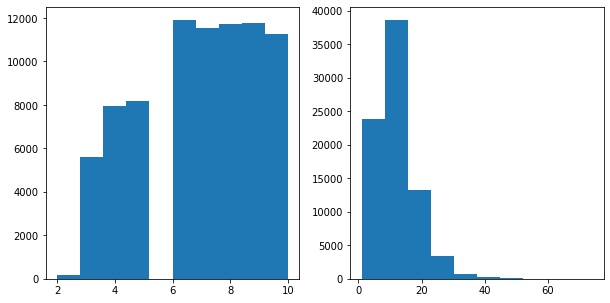

In [85]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].hist(data["query_length"], label = "query_length")
ax[1].hist(data["document_length"], label = "query_length")

<div class="alert alert-info">
    <ul>
        <li>the query length is evenly distributed from 3-10 characters except for 6 characters which has 0 records</li>
        <li>while the length of the document has some outliers, but most of its values are under 20 characters</li>
    </ul>
</div>

(array([3.0558e+04, 8.9000e+02, 9.3800e+03, 1.7888e+04, 3.8000e+02,
        1.4063e+04, 1.3960e+03, 2.3000e+01, 0.0000e+00, 5.5810e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

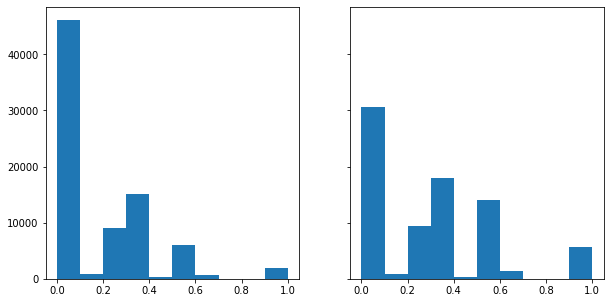

In [86]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharey = True)

ax[0].hist(data["jaccard_entire"])
ax[1].hist(data["sub_jaccard"])

<div class="alert alert-success">
    <ul>
        <li>There's a lot of zeros in the jaccard similarities wether it's for the whole word or for a sub, but it's more extreme with whole words </li>
        <li>sub- jacard has more records with a 1 values but the rest of the distribution is very similar</li>
    </ul>
</div>

<div class="alert alert-info">
Let's take a look at the skewed data columns</div>

In [87]:
skewed_columns = ["elasticsearch_score", "distance", "tweets_count", "tweets_average_length", "hashtags", "mentions"]

In [88]:
def distplotDistribution(data, columns):
    '''
    function: plot a distribution plot for each column in the list
    '''
    fig, ax = plt.subplots(2,3, figsize=(25,10))
    count = 0
    for i in range(len(columns)):
        sns.distplot(data[columns[i]],ax=ax[count][i%3])
        if (i+1)%3==0: 
            count+=1
            
    fig.show()

C:\Users\Rama\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


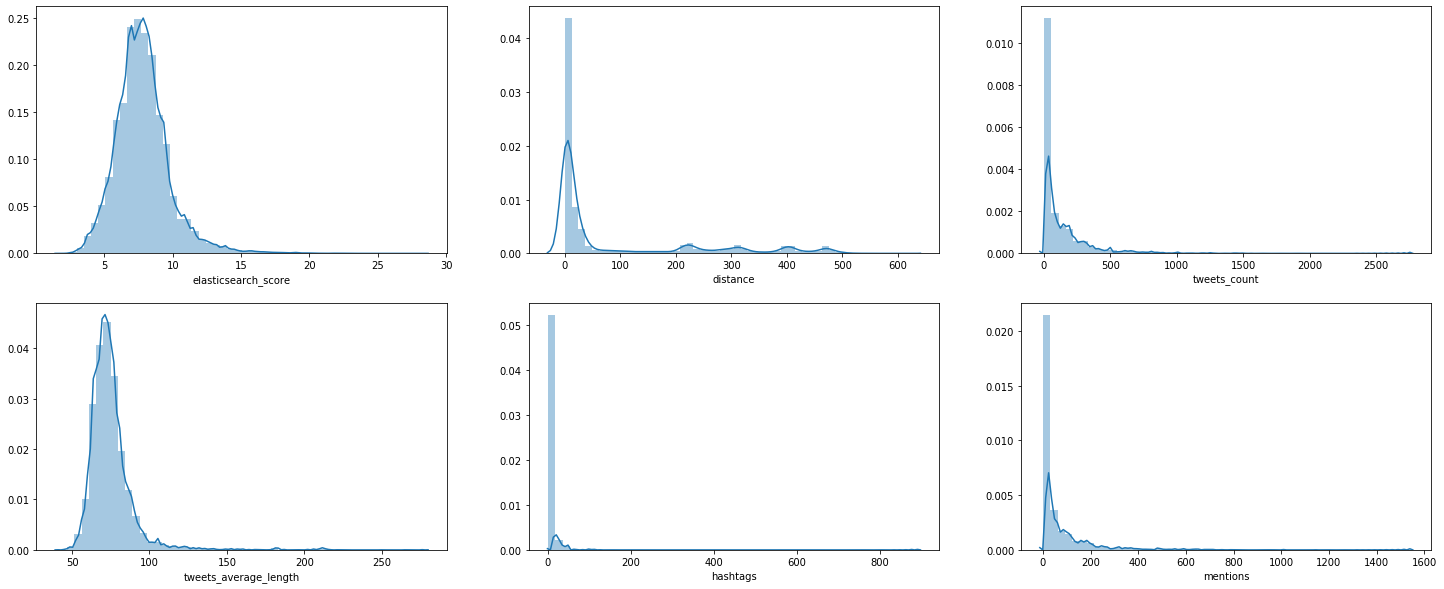

In [89]:
distplotDistribution(data, skewed_columns)

<div class="alert alert-danger">
They all are extremely skewed, and some has some great outliers.<br>
    <b>Let's apply log transform on all of them</b></div>

In [90]:
for column in skewed_columns: 
    data[column] = np.log((1+ data[column]))

C:\Users\Rama\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


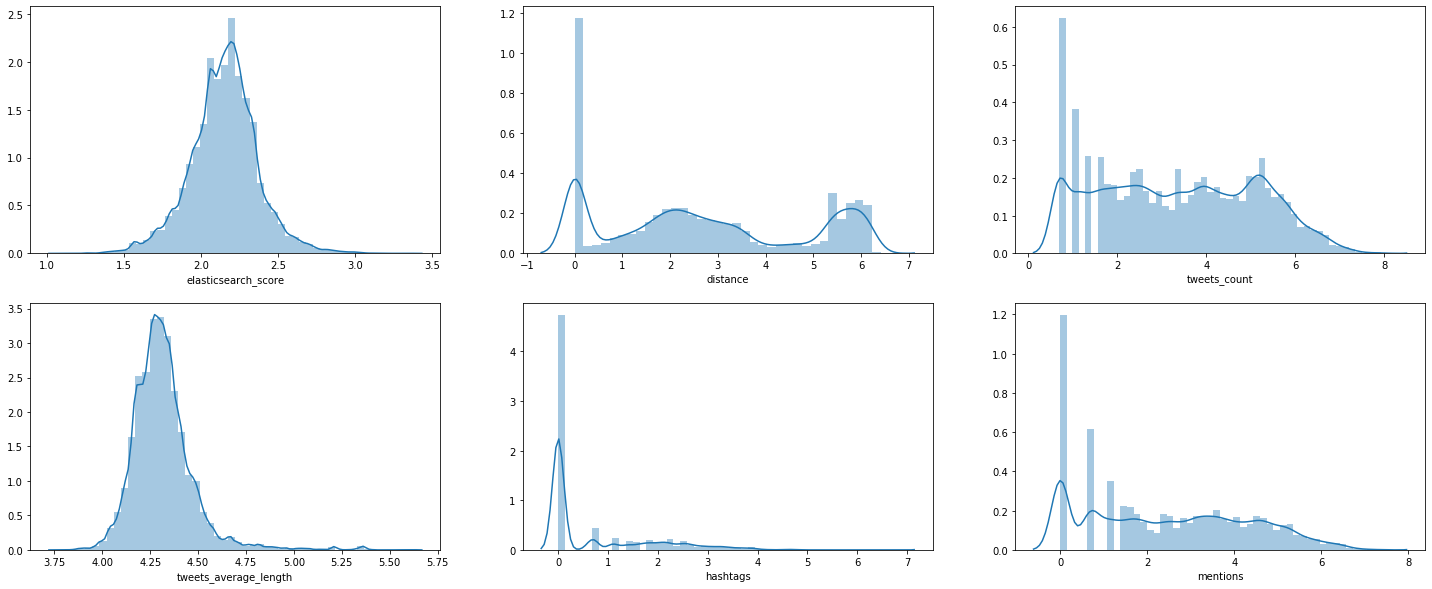

In [91]:
distplotDistribution(data, skewed_columns)

<div class="alert alert-success">
This looks a bit better</div>

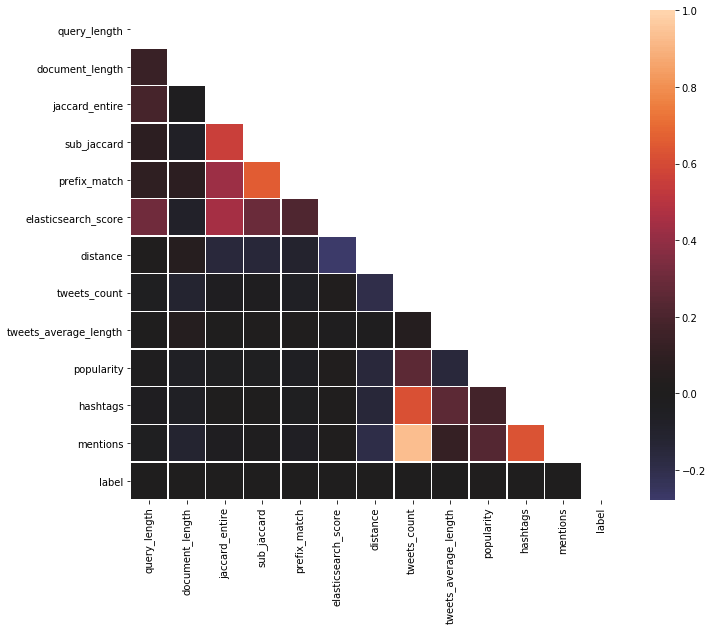

In [92]:
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap
sns.heatmap(corr, mask=mask, center=0,
            square=True, linewidths=.5)


<div class="alert alert-info">
there isn't much corelation between the label and the values</div>

In [94]:
data.to_csv('./train_data_v2.csv', index=False)

### slice training and testing datasets  <a class="anchor" id="slice"></a>

<div class="alert alert-info">
 we need to slice the data into training and testing datasets, but we have to be carefull to split the data by queries and not treat each row as an individual record
</div>

In [95]:
# get the unique values in the query feature
queries = data['query'].unique()

In [96]:
queries

array(['1025 Ruyi', '1060', '10th Avenu', ..., 'Zwanger-P', 'Zwnger-Per',
       'Z & Y'], dtype=object)

In [97]:
# get 30% of the queries as testing and the others as training 
split_index = round(len(queries)*0.30)
testing_queries = queries[:split_index]
training_queries = queries[split_index:]

In [98]:
# slice testing and training datasets
testing = data[data['query'].isin(testing_queries)]
training = data[data['query'].isin(training_queries)]

In [99]:
testing.shape

(24452, 15)

In [100]:
training.shape

(55707, 15)

<div class="alert alert-success">
 30% of the queries data represent the testing dataframw while the rest will be used for training
</div>

### get the groups set  <a class="anchor" id="groups"></a>

<div class="alert alert-info">
 for the model to understand that each row isn't an individual record and that the whole query rows are a chunck together we need to use grouping with xgb<br>
    here we're preparing the parameters for the groupings which will be used next 
</div>

In [101]:
# sort the training dataframe based on query
training = training.sort_values(by='query')

In [102]:
# get the count of documents for each query and sort it to match the dataset
groups = training['query'].value_counts().sort_index().values

In [103]:
# sort the training dataframe based on query
testing = testing.sort_values(by='query')
# get the count of documents for each query and sort it to match the dataset
groups_testing = testing['query'].value_counts().sort_index().values

## machine learning models  <a class="anchor" id="ml"></a>

### - data preparation  <a class="anchor" id="prep"></a>

<div class="alert alert-info">
    to use xgb, data of type <b>DMatrix</b> should be inputed to the model, a normal dataframe wouldn't work, so we need to creat DMatrix objects of the data.<br>
    *we will also keep the original data to use it for normal point regression
</div>

In [104]:
# delete the query and the documet featuers
training = training.drop([ 'query', 'document'], 1)

In [105]:
# create a Dmatrix for the training dataset
training_dmatrix = xgb.DMatrix(training.drop(['label'], 1), label = training['label'])

In [106]:
# create a Dmatrix for the testing dataset
testing_dmatrix= xgb.DMatrix(testing.drop(['label', 'query', 'document'], 1))

In [107]:
# set the groups values
training_dmatrix.set_group(groups)
testing_dmatrix.set_group(groups_testing)

### - point wise  <a class="anchor" id="point"></a>

<div class="alert alert-info">
 we will try to use a normal Linear regression model and see if it will predict good values or not
</div>

In [108]:
# define the training and testing datasets
X_train, X_test = training.drop(['label'], 1), testing.drop(['label', 'query', 'document'], 1)
y_train, y_test = training['label'],  testing['label']

In [109]:
# define the linear regression object and fit the model
linear_model = LinearRegression().fit(X_train, y_train)

In [110]:
# R^2 score
linear_model.score(X_test, y_test)

-0.00036376413930439

<div class="alert alert-danger">
 the accuracy is really bad, which makes sense, since linear regression treats each row as a record and isn't particularly made for ranking purposes
</div>

### - list wise <a class="anchor" id="list"></a>

<div class="alert alert-info">
 let's try to use list wise regression
</div>

#### fit the model

In [111]:
# define the parameters
ltr_lambdamart_param = [('objective','rank:ndcg'),('max_depth',3), ('eta',0.1), ('seed',404)]

# fit the model
lambdamart_model = xgb.train(ltr_lambdamart_param, training_dmatrix)

#### model evaluation - NDCG

In [113]:
# get the ndcg score for each query group
scores_lambdamart = testing.drop(['document'], 1)\
.groupby(['query'])\
.apply(lambda x: ndcg_score([lambdamart_model.predict(xgb.DMatrix(x.drop(['query', 'label'], 1)))], [x['label']]))

In [114]:
# the average ndcg for all queries
sum(scores_lambdamart.values)/len(scores_lambdamart)

0.9864529953221643

<div class="alert alert-warning">
 the accuracy is pretty high<br> let's take a look t the feature importance to understand how the model works
</div>

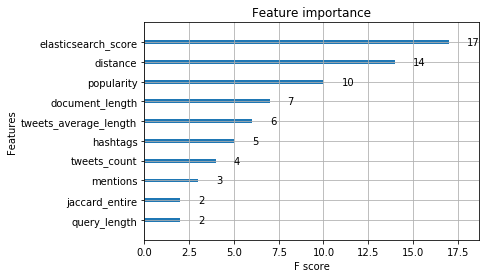

In [115]:
# the features importance
plot_importance(lambdamart_model)

### - pair wise <a class="anchor" id="pair"></a>

<div class="alert alert-info">
 pair wise should give us great results since the label is a rank
</div>

#### fit the model

In [116]:
# define the parameters
ltr_lambdarank_param = [('objective','rank:pairwise'),('max_depth',20), ('eta',0.1), ('seed',404)]

# fit the model
lambdarank_model = xgb.train(ltr_lambdarank_param, training_dmatrix)

#### model evaluation - NDCG

In [118]:
# get the ndcg score for each query group
scores = testing.drop(['document'], 1)\
.groupby(['query'])\
.apply(lambda x: ndcg_score([lambdarank_model.predict(xgb.DMatrix(x.drop(['query', 'label'], 1)))], [x['label']]))

In [119]:
# the average ndcg for all queries
sum(scores.values)/len(scores)

0.9220845604703163

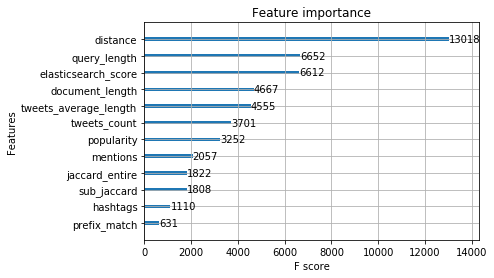

In [120]:
# the features importance
plot_importance(lambdarank_model)

<div class="alert alert-success">
 the results from the pair-wise model make the most sense, and the feature importance plot looks balanced<br>
    let's export the model
</div>

In [121]:
pickle.dump(lambdarank_model, open("./model.sav", 'wb'))

### hyperparameters tuning <a class="anchor" id="hyper"></a>

<div class="alert alert-info">
 to further improve the model hyperparameteres tuning is needed, let's check the accuracy of all the possibilities for the parameters in the model 
</div>

In [122]:
# define the base model
base_model = xgb.XGBRegressor()

# maximum number of levels in the tree
max_depth = [int(x) for x in np.linspace(5, 15, num = 10)]
max_depth.append(None)

# method of selecting samples for training each tree
learning_rate = [0.01, 0.1]

# create the random grid
random_grid = {'max_depth': max_depth,
               'learning_rate': learning_rate}

In [128]:
# Use the grid to search for best hyperparameters
xgb_grid = GridSearchCV(estimator = base_model, # the base model
                               param_grid = random_grid, # grid of hyper parameters
                               cv = 3, # 3-fold
                               verbose=2,  # print some logs while evaluating the different combinations
                               n_jobs = -1) # use all cores in the machine to train (parallel)


In [129]:
# fit the grid search m
xgb_grid.fit(training.drop(['label'], 1),  training['label'])

Fitting 3 folds for each of 22 candidates, totalling 66 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:  2.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estima...
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
         

In [131]:
# get the best model 
best_model = xgb_grid.best_estimator_

<div class="alert alert-success">
 The best estimator was found and saved! Let's evaluate it and look at its interpritation
</div>

#### model evaluation - NDCG - best model

In [133]:
# find the ndcg score for each query using the best model
best_model_scores = testing.drop(['document'], 1)\
.groupby(['query'])\
.apply(lambda x: ndcg_score([best_model.predict(x.drop(['label', 'query'], 1) )], [x['label']]))

In [134]:
# find the average ndcg score 
sum(best_model_scores.values)/len(best_model_scores)

0.994034263438377

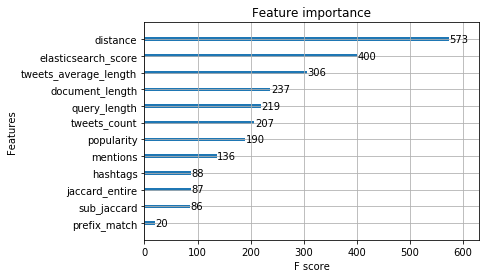

In [135]:
# the features importance
plot_importance(best_model)

### Model Interpretation <a class="anchor" id="interpret"></a>

In [136]:
import shap

In [137]:
#initialling shap to plot the plots down below
shap.initjs()

In [141]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(testing.drop(['label', 'query', 'document'], 1) )
print('Expected Value:', explainer.expected_value)
pd.DataFrame(shap_values).head()

Expected Value: 3.1341548


,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.044438,0.009792,0.000602,0.019558,0.002320,-0.030869,-0.009886,0.041219,0.025340,0.009375,-0.017334,0.009622
1,-0.017887,-0.003296,0.001606,-0.008925,0.001580,0.016541,0.027389,-0.015553,-0.009845,0.008427,0.001792,0.005486
2,-0.026172,0.019566,0.004315,0.002109,0.000369,-0.004207,0.027006,0.003905,0.001650,0.004838,0.005090,0.013976
3,-0.024980,0.016084,0.001239,-0.005018,-0.029493,-0.130831,0.052662,0.082272,0.050134,0.009926,0.099638,-0.062955
4,0.001668,0.035004,-0.001504,-0.003708,0.004921,0.014262,-0.027637,-0.012794,-0.016825,-0.011178,-0.027276,-0.001436


<div class="alert alert-success">
Each row in this dataframe sums to the difference between the model output for that sample and the expected value of the model output (which is stored as expected_value = 3.1341548), this helps explain why the model predicts such skewed values </div>

<div class="alert alert-info">
    int the following 3 plots show the affect of each feature to get such a value, we plotted them on the expected_value we calculated above, on 1 the lowest rank and on 5 the highest rank <br>
the blue values helped making the prediction less, while the red one contributed in making it higher<br>
</div>

In [143]:
shap.force_plot(explainer.expected_value, 
                shap_values[0,:], X_test.iloc[0,:])

<div class="alert alert-info">
   *shap library plots don't show in github, so the plot is displayed as an image here
    <img src="plots/force_plot1.png">
</div>


In [152]:
shap.force_plot(1, 
                shap_values[0,:], X_test.iloc[0,:])

<div class="alert alert-info">
   *shap library plots don't show in github, so the plot is displayed as an image here
    <img src="plots/force_plot2.png">
</div>


In [153]:
shap.force_plot(5, 
                shap_values[2,:], X_test.iloc[2,:])

<div class="alert alert-info">
   *shap library plots don't show in github, so the plot is displayed as an image here
    <img src="plots/force_plot3.png">
</div>

<div class="alert alert-success">
    <ul>
        <li>the <b>tweets count</b> feature helped the most to push the rank up for when the rank was 3 and 1, while the <b>query length and elasticsearch_score</b> helped push them down</li>
        <li>when the rank was 5, the <b>distance</b> was what mostly pushed the rank up</li>
    </ul>
</div>

In [155]:
shap.force_plot(5, 
                shap_values[:1000,:], X_test.iloc[:1000,:])

<div class="alert alert-success">
    the above plot explains what really affected the model to get a rank of 5, after analyzing it, the following was concluded:
    <ul>
        <li>the elastic search score mostly pushed the rank higher(sometimes drastically) but sometimes it did push it lower but not extremely. so this feature mostly helped pushing the rank up when the rank was 5</li>
        <li>the distance though has a more of a balanced affect, the amount of time it pushed the score higher and lower is about the same with similar affect in both ways. </li>
        <li>the popularity's affect though was stronger pushing down rather than up, it did push both ways a balanced number of times but it was more drastic down</li>
    </ul>
</div>

<div class="alert alert-info">
   *shap library plots don't show in github, so the plot is displayed as an image here
    <img src="plots/forceMultiple1.png">
    <img src="plots/forceMultiple2.png">
    <img src="plots/forceMultiple3.png">

</div>
